In [1]:
%matplotlib inline
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
# CSVファイルの読み込み
df = pd.read_csv('xy(1).csv')

# データの抽出
x = df['x'].values
y = df['y'].values

x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(y, dtype=torch.float32)

In [3]:
def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    K = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
])    
    # 63個のスカラー結果を得るための計算
    K1 = torch.einsum('ij,jk,ik->i', h, K, h)
    return K1

# パラメータの定義
k1 = torch.tensor(-8.572, requires_grad=True)
k2 = torch.tensor(1.146, requires_grad=True)
k3 = torch.tensor(0.0, requires_grad=True)
k4 = torch.tensor(8.830, requires_grad=True)
k5 = torch.tensor(0.0, requires_grad=True)
k6 = torch.tensor(0.0, requires_grad=True)
t1 = torch.tensor(0.0, requires_grad=True)
p1 = torch.tensor(0.0, requires_grad=True)
t2 = torch.tensor(90.0, requires_grad=True)
p2 = torch.tensor(0.0, requires_grad=True)

# 各xに対する勾配計算の準備
k1_grads = []
k2_grads = []
k3_grads = []
k4_grads = []
k5_grads = []
k6_grads = []
t1_grads = []
p1_grads = []
t2_grads = []
p2_grads = []

for i in range(len(x)):
    # 1つのx値に対してモデルを計算
    y_p = model(x[i:i+1], k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    
    # 勾配計算のためのテンソル
    v = torch.ones_like(y_p)
    
    # 勾配計算
    y_p.backward(v, retain_graph=True)
    
    # 各パラメータの勾配を保存
    k1_grads.append(k1.grad.item())
    k2_grads.append(k2.grad.item())
    k3_grads.append(k3.grad.item())
    k4_grads.append(k4.grad.item())
    k5_grads.append(k5.grad.item())
    k6_grads.append(k6.grad.item())
    t1_grads.append(t1.grad.item())
    p1_grads.append(p1.grad.item())
    t2_grads.append(t2.grad.item())
    p2_grads.append(p2.grad.item())
    
    # 勾配のリセット
    k1.grad.zero_()
    k2.grad.zero_()
    k3.grad.zero_()
    k4.grad.zero_()
    k5.grad.zero_()
    k6.grad.zero_()
    t1.grad.zero_()
    p1.grad.zero_()
    t2.grad.zero_()
    p2.grad.zero_()

# リストをtorch.tensorに変換
k1_grads = torch.tensor(k1_grads)
k2_grads = torch.tensor(k2_grads)
k3_grads = torch.tensor(k3_grads)
k4_grads = torch.tensor(k4_grads)
k5_grads = torch.tensor(k5_grads)
k6_grads = torch.tensor(k6_grads)
t1_grads = torch.tensor(t1_grads)
p1_grads = torch.tensor(p1_grads)
t2_grads = torch.tensor(t2_grads)
p2_grads = torch.tensor(p2_grads)

# 勾配の出力
print(f'k1.grad: {k1_grads}')
print(f'k2.grad: {k2_grads}')
print(f'k3.grad: {k3_grads}')
print(f'k4.grad: {k4_grads}')
print(f'k5.grad: {k5_grads}')
print(f'k6.grad: {k6_grads}')
print(f't1.grad: {t1_grads}')
print(f'p1.grad: {p1_grads}')
print(f't2.grad: {t2_grads}')
print(f'p2.grad: {p2_grads}')

k1.grad: tensor([1.0000e+00, 9.9960e-01, 9.9750e-01, 9.9426e-01, 9.8971e-01,
        9.8386e-01, 9.7670e-01, 9.6895e-01, 9.6339e-01, 9.5775e-01,
        9.4678e-01, 9.3464e-01, 9.2134e-01, 9.0693e-01, 8.9097e-01,
        8.6389e-01, 8.4577e-01, 8.2674e-01, 8.0686e-01, 7.8712e-01,
        7.5876e-01, 7.3879e-01, 7.1347e-01, 6.8997e-01, 6.6596e-01,
        6.4153e-01, 6.1842e-01, 6.0056e-01, 5.7318e-01, 5.8592e-01,
        5.4768e-01, 5.2206e-01, 4.9638e-01, 4.7071e-01, 4.4709e-01,
        4.2514e-01, 4.0353e-01, 3.7625e-01, 3.5154e-01, 3.2721e-01,
        3.0333e-01, 2.7996e-01, 2.6036e-01, 2.4542e-01, 2.2525e-01,
        2.0415e-01, 1.8381e-01, 1.6432e-01, 1.4653e-01, 1.2683e-01,
        1.1309e-01, 9.5673e-02, 8.1075e-02, 6.7587e-02, 5.5238e-02,
        4.5804e-02, 3.3888e-02, 2.6553e-02, 1.9164e-02, 1.2739e-02,
        7.6074e-03, 9.8053e-05, 4.8560e-05])
k2.grad: tensor([9.0945e-07, 4.0094e-04, 2.5031e-03, 5.7392e-03, 1.0289e-02,
        1.6141e-02, 2.3296e-02, 3.1054e-02, 3.6607e-0

In [4]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [5]:
loss = loss_fn(y_p, y)
loss

tensor(34.8626, grad_fn=<MeanBackward0>)

In [6]:
# x = torch.ones(())
# y = torch.ones(3,1)
# z = torch.ones(1,3)
# a = torch.ones(2, 1, 1)
# print(f"shapes: x: {x.shape}, y: {y.shape}")
# print(f"        z: {z.shape}, a: {a.shape}")
# print("x * y:", (x * y).shape)
# print("y * z:", (y * z).shape)
# print("y * z * a:", (y * z * a).shape)

In [7]:
delta = 0.1

learning_rate = 1e-2

loss_rate_of_change_k1 = \
    (loss_fn(model(x, k1 + delta, k2, k3, k4, k5, k6, t1, p1, t2, p2), y) - 
     loss_fn(model(x, k1 - delta, k2, k3, k4, k5, k6, t1, p1, t2, p2), y)) / (2.0 * delta)

k1 = k1 - learning_rate * loss_rate_of_change_k1

loss_rate_of_change_k2 = \
    (loss_fn(model(x, k1, k2 + delta, k3, k4, k5, k6, t1, p1, t2, p2), y) - 
     loss_fn(model(x, k1, k2 - delta, k3, k4, k5, k6, t1, p1, t2, p2), y)) / (2.0 * delta)

k2 = k2 - learning_rate * loss_rate_of_change_k2

loss_rate_of_change_k3 = \
    (loss_fn(model(x, k1, k2, k3 + delta, k4, k5, k6, t1, p1, t2, p2), y) - 
     loss_fn(model(x, k1, k2, k3 - delta, k4, k5, k6, t1, p1, t2, p2), y)) / (2.0 * delta)

k3 = k3 - learning_rate * loss_rate_of_change_k3

loss_rate_of_change_k4 = \
    (loss_fn(model(x, k1, k2, k3, k4 + delta, k5, k6, t1, p1, t2, p2), y) - 
     loss_fn(model(x, k1, k2, k3, k4 - delta, k5, k6, t1, p1, t2, p2), y)) / (2.0 * delta)

k4 = k4 - learning_rate * loss_rate_of_change_k4

loss_rate_of_change_k5 = \
    (loss_fn(model(x, k1, k2, k3, k4, k5 + delta, k6, t1, p1, t2, p2), y) - 
     loss_fn(model(x, k1, k2, k3, k4, k5 - delta, k6, t1, p1, t2, p2), y)) / (2.0 * delta)

k5 = k5 - learning_rate * loss_rate_of_change_k5

loss_rate_of_change_k6 = \
    (loss_fn(model(x, k1, k2, k3, k4, k5, k6 + delta, t1, p1, t2, p2), y) - 
     loss_fn(model(x, k1, k2, k3, k4, k5, k6 - delta, t1, p1, t2, p2), y)) / (2.0 * delta)

k6 = k6 - learning_rate * loss_rate_of_change_k6

loss_rate_of_change_t1 = \
    (loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1 + delta, p1, t2, p2), y) - 
     loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1 - delta, p1, t2, p2), y)) / (2.0 * delta)

t1 = t1 - learning_rate * loss_rate_of_change_t1

loss_rate_of_change_p1 = \
    (loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1 + delta, t2, p2), y) - 
     loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1 - delta, t2, p2), y)) / (2.0 * delta)

p1 = p1 - learning_rate * loss_rate_of_change_p1

loss_rate_of_change_t2 = \
    (loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2 + delta, p2), y) - 
     loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2 - delta, p2), y)) / (2.0 * delta)

t2 = t2 - learning_rate * loss_rate_of_change_t2

loss_rate_of_change_p2 = \
    (loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 + delta), y) - 
     loss_fn(model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 - delta), y)) / (2.0 * delta)

p2 = p2 - learning_rate * loss_rate_of_change_p2

In [8]:
def dloss_fn(y_p, y):
    dsq_diffs = 2 * (y_p - y) / y_p.size(0)  # <1>
    return dsq_diffs

In [9]:
def dmodel_dk1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    return k1_grads

def dmodel_dk2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    return k2_grads

def dmodel_dk3(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    return k3_grads

def dmodel_dk4(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    return k4_grads

def dmodel_dk5(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    return k5_grads

def dmodel_dk6(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    return k6_grads

def dmodel_dt1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    return t1_grads

def dmodel_dp1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    return p1_grads

def dmodel_dt2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    return t2_grads

def dmodel_dp2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    return p2_grads

In [10]:
def grad_fn(x, y, y_p, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    dloss_dyp = dloss_fn(y_p, y)
    dloss_dk1 = dloss_dyp * dmodel_dk1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    dloss_dk2 = dloss_dyp * dmodel_dk2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    dloss_dk3 = dloss_dyp * dmodel_dk3(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    dloss_dk4 = dloss_dyp * dmodel_dk4(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    dloss_dk5 = dloss_dyp * dmodel_dk5(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    dloss_dk6 = dloss_dyp * dmodel_dk6(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    dloss_dt1 = dloss_dyp * dmodel_dt1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    dloss_dp1 = dloss_dyp * dmodel_dp1(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    dloss_dt2 = dloss_dyp * dmodel_dt2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    dloss_dp2 = dloss_dyp * dmodel_dp2(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    return torch.stack([dloss_dk1.sum(), dloss_dk2.sum(), dloss_dk3.sum(), dloss_dk4.sum(), dloss_dk5.sum(), dloss_dk6.sum(), dloss_dt1.sum(), dloss_dp1.sum(), dloss_dt2.sum(), dloss_dp2.sum()])  # <1>

In [11]:
def training_loop(n_epochs, learning_rate, params, x, y):
    for epoch in range(1, n_epochs + 1):
        k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = params

        y_p = model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)  # <1>
        loss = loss_fn(y_p, y)
        grad = grad_fn(x, y, y_p, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)  # <2>
        
        print(grad)
        print(grad.shape)

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

In [12]:
def training_loop(n_epochs, learning_rate, params, x, y,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = params

        y_p = model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)  # <1>
        loss = loss_fn(y_p, y)
        grad = grad_fn(x, y, y_p, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [13]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([-8.572, 1.146, 0.0, 8.830, 0.0, 0.0, 0.0, 0.0, 90.0, 0.0]), 
    x = x, 
    y = y)

Epoch 1, Loss 0.023659
    Params: tensor([-8.5706e+00,  1.1475e+00,  5.6215e-18,  8.8300e+00, -1.6268e-10,
         1.8661e-03,  2.9293e-04,  0.0000e+00,  8.9999e+01,  3.1652e-04],
       grad_fn=<SubBackward0>)
    Grad:   tensor([-1.4471e-01, -1.4950e-01, -5.6215e-16,  1.6465e-08,  1.6268e-08,
        -1.8661e-01, -2.9293e-02,  0.0000e+00,  5.8052e-02, -3.1652e-02],
       grad_fn=<StackBackward0>)
Epoch 2, Loss 0.022834
    Params: tensor([-8.5691e+00,  1.1490e+00,  1.1134e-17,  8.8300e+00, -3.2214e-10,
         3.6919e-03,  5.8059e-04,  0.0000e+00,  8.9999e+01,  6.2619e-04],
       grad_fn=<SubBackward0>)
    Grad:   tensor([-1.4190e-01, -1.4663e-01, -5.5129e-16,  1.6140e-08,  1.5946e-08,
        -1.8258e-01, -2.8767e-02,  0.0000e+00,  5.6905e-02, -3.0968e-02],
       grad_fn=<StackBackward0>)
Epoch 3, Loss 0.022041
    Params: tensor([-8.5677e+00,  1.1504e+00,  1.6541e-17,  8.8300e+00, -4.7845e-10,
         5.4782e-03,  8.6310e-04,  0.0000e+00,  8.9998e+01,  9.2917e-04],
       g

tensor([-8.5062e+00,  1.2146e+00,  2.5666e-16,  8.8300e+00, -7.2340e-09,
         7.3720e-02,  1.4424e-02,  0.0000e+00,  8.9974e+01,  1.2504e-02],
       grad_fn=<SubBackward0>)

In [14]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([-8.572, 1.146, 0.0, 8.830, 0.0, 0.0, 0.0, 0.0, 90.0, 0.0]), 
    x = x, 
    y = y)

Epoch 1, Loss 0.023659
    Params: tensor([-8.5720e+00,  1.1460e+00,  5.6215e-20,  8.8300e+00, -1.6268e-12,
         1.8661e-05,  2.9293e-06,  0.0000e+00,  9.0000e+01,  3.1652e-06],
       grad_fn=<SubBackward0>)
    Grad:   tensor([-1.4471e-01, -1.4950e-01, -5.6215e-16,  1.6465e-08,  1.6268e-08,
        -1.8661e-01, -2.9293e-02,  0.0000e+00,  5.8052e-02, -3.1652e-02],
       grad_fn=<StackBackward0>)
Epoch 2, Loss 0.023650
    Params: tensor([-8.5720e+00,  1.1460e+00,  1.1242e-19,  8.8300e+00, -3.2532e-12,
         3.7318e-05,  5.8580e-06,  0.0000e+00,  9.0000e+01,  6.3296e-06],
       grad_fn=<SubBackward0>)
    Grad:   tensor([-1.4468e-01, -1.4947e-01, -5.6204e-16,  1.6462e-08,  1.6265e-08,
        -1.8657e-01, -2.9287e-02,  0.0000e+00,  5.8040e-02, -3.1644e-02],
       grad_fn=<StackBackward0>)
Epoch 3, Loss 0.023641
    Params: tensor([-8.5720e+00,  1.1460e+00,  1.6861e-19,  8.8300e+00, -4.8794e-12,
         5.5971e-05,  8.7861e-06,  0.0000e+00,  9.0000e+01,  9.4933e-06],
       g

tensor([-8.5706e+00,  1.1475e+00,  5.5675e-18,  8.8300e+00, -1.6108e-10,
         1.8461e-03,  2.9029e-04,  0.0000e+00,  8.9999e+01,  3.1311e-04],
       grad_fn=<SubBackward0>)

In [15]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([-8.572, 1.146, 0.0, 8.830, 0.0, 0.0, 0.0, 0.0, 90.0, 0.0]), 
    x = x, 
    y = y,
    print_params = False)

params

Epoch 1, Loss 0.023659
Epoch 2, Loss 0.022834
Epoch 3, Loss 0.022041
...
Epoch 10, Loss 0.017321
Epoch 11, Loss 0.016751
...
Epoch 99, Loss 0.003378
Epoch 100, Loss 0.003361
...
Epoch 4000, Loss 0.001944
Epoch 5000, Loss 0.001944


tensor([-8.4307e+00,  1.2911e+00,  5.4793e-16,  8.8300e+00, -1.5164e-08,
        -1.0930e-02,  3.9535e-02,  0.0000e+00,  8.9962e+01, -1.8539e-03],
       grad_fn=<SubBackward0>)

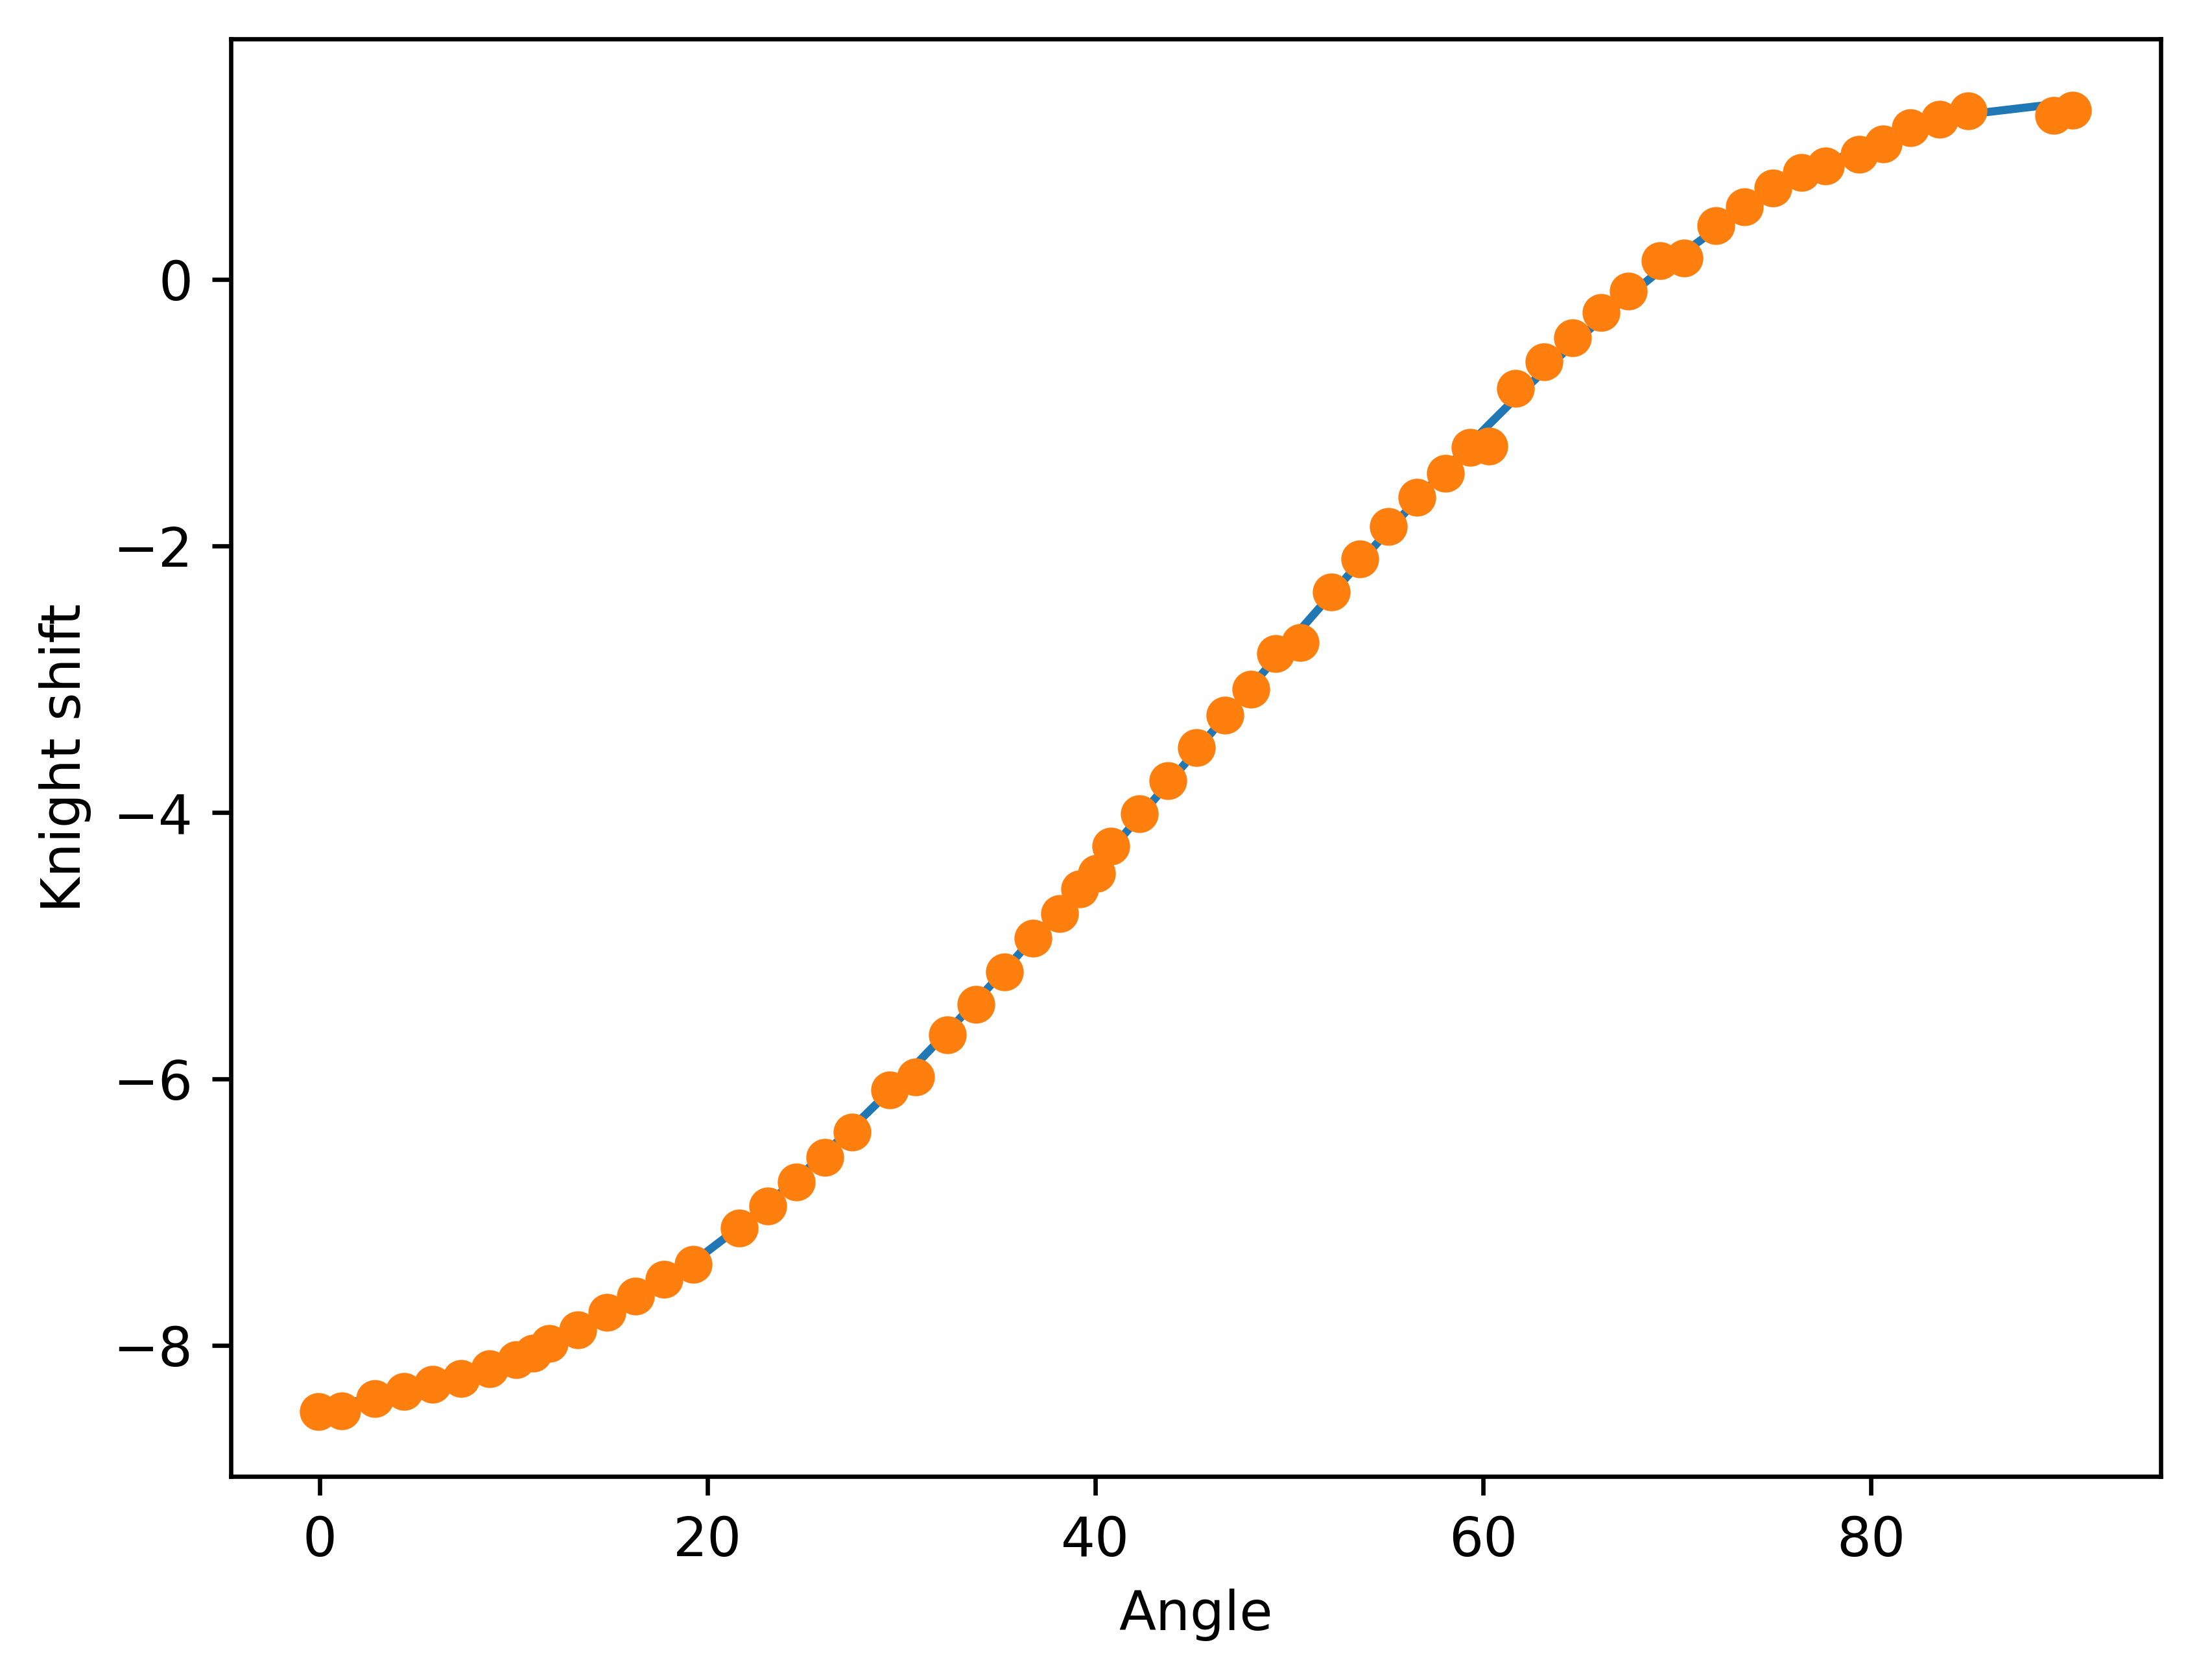

In [16]:
y_p = model(x, *params)  # <1>

fig = plt.figure(dpi=600)
plt.plot(x.detach().numpy(), y_p.detach().numpy()) # <2>
plt.plot(x.detach().numpy(), y.numpy(), 'o')
plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.show()